In [32]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Add src to path
import sys
sys.path.append('..')

from src.config import CLEANED_DATA_PATH, FEATURED_DATA_PATH, TARGET_COLUMN, DATE_COLUMN
from src.feature_engineering import (
    add_temporal_features, add_cyclical_features,
    add_weather_features, add_interaction_features, 
    feature_engineering_pipeline
)
from src.utils import save_csv

print("Libraries imported successfully!")
print("\nNote: Lag/Rolling/Diff features NOT used - LSTM learns from sequences")

Libraries imported successfully!

Note: Lag/Rolling/Diff features NOT used - LSTM learns from sequences


## 3.1 Load Cleaned Data

In [33]:
# Load cleaned data
df = pd.read_csv(CLEANED_DATA_PATH, parse_dates=[DATE_COLUMN])
print(f"Loaded data shape: {df.shape}")
print(f"Original columns: {df.columns.tolist()}")
df.head()

Loaded data shape: (40575, 19)
Original columns: ['date_time', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume', 'weather_description', 'holiday', 'Clear', 'Clouds', 'Drizzle', 'Fog', 'Haze', 'Mist', 'Rain', 'Smoke', 'Snow', 'Squall', 'Thunderstorm']


,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume,weather_description,holiday,Clear,Clouds,Drizzle,Fog,Haze,Mist,Rain,Smoke,Snow,Squall,Thunderstorm
0,2012-10-02 09:00:00,288.28,0.0,0.0,40.0,5545.0,scattered clouds,0,0,1,0,0,0,0,0,0,0,0,0
1,2012-10-02 10:00:00,289.36,0.0,0.0,75.0,4516.0,broken clouds,0,0,1,0,0,0,0,0,0,0,0,0
2,2012-10-02 11:00:00,289.58,0.0,0.0,90.0,4767.0,overcast clouds,0,0,1,0,0,0,0,0,0,0,0,0
3,2012-10-02 12:00:00,290.13,0.0,0.0,90.0,5026.0,overcast clouds,0,0,1,0,0,0,0,0,0,0,0,0
4,2012-10-02 13:00:00,291.14,0.0,0.0,75.0,4918.0,broken clouds,0,0,1,0,0,0,0,0,0,0,0,0


## 3.2 Temporal Features

In [34]:
# Add temporal features
df = add_temporal_features(df, DATE_COLUMN)

# View new features
temporal_cols = ['hour', 'day_of_week', 'day_of_month', 'month', 'year', 
                 'week_of_year', 'quarter', 'is_weekend', 'is_rush_hour', 'season']
df[temporal_cols].head(10)

Added temporal features: hour, day_of_week, day_of_month, month, year, week_of_year, quarter, is_weekend, is_rush_hour, season


,hour,day_of_week,day_of_month,month,year,week_of_year,quarter,is_weekend,is_rush_hour,season
0,9,1,2,10,2012,40,4,0,1,2
1,10,1,2,10,2012,40,4,0,0,2
2,11,1,2,10,2012,40,4,0,0,2
3,12,1,2,10,2012,40,4,0,0,2
4,13,1,2,10,2012,40,4,0,0,2
5,14,1,2,10,2012,40,4,0,0,2
6,15,1,2,10,2012,40,4,0,0,2
7,16,1,2,10,2012,40,4,0,1,2
8,17,1,2,10,2012,40,4,0,1,2
9,18,1,2,10,2012,40,4,0,1,2


## 3.3 Cyclical Features

Added cyclical features: hour_sin/cos, day_sin/cos, month_sin/cos


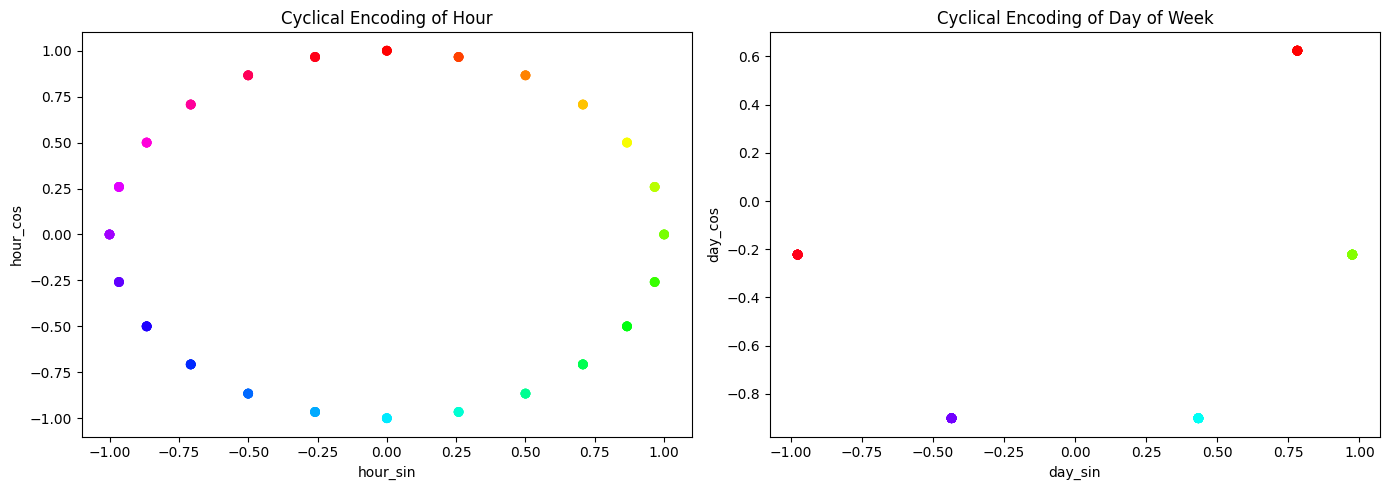

In [35]:
# Add cyclical encoding
df = add_cyclical_features(df)

# Visualize cyclical encoding for hour
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Hour sin/cos
sample = df.head(100)
axes[0].scatter(sample['hour_sin'], sample['hour_cos'], c=sample['hour'], cmap='hsv')
axes[0].set_xlabel('hour_sin')
axes[0].set_ylabel('hour_cos')
axes[0].set_title('Cyclical Encoding of Hour')

# Day sin/cos
axes[1].scatter(sample['day_sin'], sample['day_cos'], c=sample['day_of_week'], cmap='hsv')
axes[1].set_xlabel('day_sin')
axes[1].set_ylabel('day_cos')
axes[1].set_title('Cyclical Encoding of Day of Week')

plt.tight_layout()
plt.show()

## 3.4 Weather Features

In [36]:
# Add weather features
df = add_weather_features(df)

# View weather features
weather_cols = ['temp_celsius', 'temp_category', 'is_rainy', 'is_snowy']
df[weather_cols].describe()

Added weather features: temp_celsius, temp_category, is_rainy, is_snowy, cloud_category, weather_encoded


,temp_celsius,temp_category,is_rainy,is_snowy
count,40575.000000,40575.000000,40575.000000,40575.000000
mean,8.165882,1.446802,0.050647,0.000764
std,13.817217,1.140940,0.219278,0.027631
min,-273.150000,0.000000,0.000000,0.000000
25%,-1.310000,0.000000,0.000000,0.000000
50%,9.710000,1.000000,0.000000,0.000000
75%,19.130000,2.000000,0.000000,0.000000
max,36.920000,4.000000,1.000000,1.000000


## 3.5 Interaction Features

In [37]:
# Add interaction features
df = add_interaction_features(df)

# View interaction features
interaction_cols = ['rush_rain']
df[interaction_cols].head(10)

Added interaction features: hour_weekend, hour_holiday, rush_rain, temp_rush


,rush_rain
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


## 3.6 Verify Data Quality

In [38]:
# Check NaN values (should be minimal without lag/rolling features)
nan_counts = df.isnull().sum()
nan_cols = nan_counts[nan_counts > 0]

if len(nan_cols) > 0:
    print(f"Columns with NaN values: {len(nan_cols)}")
    print(nan_cols)
else:
    print("No NaN values - ready for feature selection!")

No NaN values - ready for feature selection!


## 3.7 Feature Summary

In [42]:
# Summary of all features
print("=" * 60)
print("FEATURE ENGINEERING SUMMARY")
print("=" * 60)
print(f"Total features: {df.shape[1]}")
print(f"Total samples: {df.shape[0]:,}")
print("\nFeature categories:")
print(f"  - Original features: temp, rain_1h, snow_1h, clouds_all, traffic_volume")
print(f"  - Temporal features: hour, day_of_week, day_of_month, month, year, week_of_year, quarter, is_weekend, is_rush_hour, season")
print(f"  - Cyclical features: hour_sin/cos, day_sin/cos, month_sin/cos")
print(f"  - Weather features: temp_celsius, is_rainy, is_snowy")
print(f"  - Interaction features: rush_rain")
print("=" * 60)

FEATURE ENGINEERING SUMMARY
Total features: 43
Total samples: 40,575

Feature categories:
  - Original features: temp, rain_1h, snow_1h, clouds_all, traffic_volume
  - Temporal features: hour, day_of_week, day_of_month, month, year, week_of_year, quarter, is_weekend, is_rush_hour, season
  - Cyclical features: hour_sin/cos, day_sin/cos, month_sin/cos
  - Weather features: temp_celsius, is_rainy, is_snowy
  - Interaction features: rush_rain


In [43]:
# List all feature columns
print(f"\nAll {len(df.columns)} columns:")
for i, col in enumerate(df.columns):
    print(f"{i+1:3d}. {col}")


All 43 columns:
  1. date_time
  2. temp
  3. rain_1h
  4. snow_1h
  5. clouds_all
  6. traffic_volume
  7. weather_description
  8. holiday
  9. Clear
 10. Clouds
 11. Drizzle
 12. Fog
 13. Haze
 14. Mist
 15. Rain
 16. Smoke
 17. Snow
 18. Squall
 19. Thunderstorm
 20. hour
 21. day_of_week
 22. day_of_month
 23. month
 24. year
 25. week_of_year
 26. quarter
 27. is_weekend
 28. is_rush_hour
 29. season
 30. hour_sin
 31. hour_cos
 32. day_sin
 33. day_cos
 34. month_sin
 35. month_cos
 36. temp_celsius
 37. temp_category
 38. is_rainy
 39. is_snowy
 40. cloud_category
 41. hour_weekend
 42. rush_rain
 43. temp_rush


## 3.12 Save Featured Data

In [44]:
# Save to CSV
save_csv(df, FEATURED_DATA_PATH, index=False)

print(f"\nFeatured data saved to: {FEATURED_DATA_PATH}")

Saved: d:\DeepLearning_final\data\processed\featured_data.csv

Featured data saved to: d:\DeepLearning_final\data\processed\featured_data.csv


## Summary

**Feature Engineering completed:**
1. ✅ Temporal features (hour, day, month, week, season, etc.)
2. ✅ Cyclical encoding (sin/cos for hour, day, month)
3. ✅ Weather features (temp_celsius, is_rainy, is_snowy)
4. ✅ Interaction features (rush_rain)
5. ✅ Saved featured data


**Next step:** Feature Selection (04_Feature_Selection.ipynb)